In [231]:
import math
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
# sudo apt-get install texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
fontsize=25

def replace_graph_names(df):
    df["Input Graph"] = df["Input Graph"].str.replace("com-", "", regex=True)\
                                    .str.replace(".gbbs.txt", "", regex=True)\
                                    .str.replace(".bin", "", regex=True)\
                                    .str.replace(".ungraph.txt", "", regex=True)\
                                    .str.replace(".graph.txt", "", regex=True)
    df["Clusterer Name"] = df["Clusterer Name"].str.replace("Scan", "SCAN", regex=True)\
                                    .str.replace("Tectonic", "TECTONIC", regex=True)\
                                    .str.replace("Hac", "HAC", regex=True)

def set_face_grid_ax_ticks(g):
    """Set fontsize for x and y axis ticks for all axes in a FacetGrid."""
    for ax in g.axes.flat:
        set_ax_ticks(ax)


def set_ax_ticks(ax):
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(fontsize)
        
def common_ax_style(ax):
    ax.set_xticks([1, 4, 8, 16, 30, 60])
    ax.set_xticklabels([1, 4, 8, 16, 30, "30h"])
    
    ax.set_yscale('log')
    # plt.yticks([0.03, 0.1, 0.3, 1])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    set_ax_ticks(ax)
        
    ax.set_xlabel("Threads", fontsize = fontsize)

def plot_data(df, ax):
    sns.lineplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", linewidth = 3, ax = ax)
    sns.scatterplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", s = 30, ax = ax, legend=False)

def get_larger_handles(g, marker_size, ncol):
    g.add_legend(loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.15), fontsize=fontsize)
    if g._legend:
        for leg_handle in g._legend.legendHandles:
            leg_handle._sizes = [marker_size]

# Function to extract epsilon value from the config
def extract_epsilon(config):
    parts = config.split(',')
    for part in parts:
        if 'epsilon' in part:
            return part.split(':')[-1].strip()
    return None

def postpend_epsilon(df):
    df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)

def add_epsilon_to_hac(df, remove_zero_eps = True):
    df_no_parhac = df[df["Clusterer Name"] != "ParHACClusterer"]
    df_parhac = df[df["Clusterer Name"] == "ParHACClusterer"]

    # split parhac to different methods for different epsilon
    postpend_epsilon(df_parhac)
    
    if remove_zero_eps:
        df_parhac = df_parhac[df_parhac["Clusterer Name"] != "ParHACClusterer_0"]

    df_new = pd.concat([df_no_parhac, df_parhac])
    
    return df_new

def remove_small_f1_methods(df):
    # filter out methods that can achieve > 0.5 * max f1 score
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        df_graph = df[df["Input Graph"] == graph]
        max_f1 = df_graph["fScore_mean"].max()
        print(graph, max_f1)
        df_graph_filtered = df_graph[df_graph["fScore_mean"] > 0.5 * max_f1]
        methods = df_graph_filtered["Clusterer Name"].unique()
        df_graph = df_graph[df_graph["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

In [156]:
base_addr = "/Users/sy/Desktop/MIT/clusterer/csv/"

In [217]:
color_map = {'LDDClusterer': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'SCANClusterer': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274,
  1.0),
 'LabelPropagationClusterer': (1.0,
  0.4980392156862745,
  0.054901960784313725,
  1.0),
 'SLPAClusterer': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'TECTONICClusterer': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'ParallelAffinityClusterer': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353,
  1.0),
 'NetworKitPLM': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'NetworKitParallelLeiden': (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 'ConnectivityClusterer': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'ParallelModularityClusterer': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589,
  1.0),
 'ParallelCorrelationClusterer': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  1.0),
 'Neo4jLouvain': (0.7686274509803922,
  0.611764705882353,
  0.5803921568627451,
  1.0),
 'Neo4jLeiden': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'Neo4jModularityOptimization': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274,
  1.0),
 'SnapCNM': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'SnapGirvanNewman': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'SnapInfomap': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'TigerGraphLouvain': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353,
  1.0),
 'ParHACClusterer_0.01': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'ParHACClusterer_0.1': (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 'ParHACClusterer_1': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'KCoreClusterer': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0)}

style_map = {'LDDClusterer': 'o',
 "KCoreClusterer": 'D',
 'SCANClusterer': 's',
 'LabelPropagationClusterer': '^',
 'SLPAClusterer': 'P',
 'TECTONICClusterer': 'd',
 'ConnectivityClusterer': 'X',
 'ParallelAffinityClusterer': 'v',
 'ParallelCorrelationClusterer': '<',
 'ParallelModularityClusterer': '>',
 'NetworKitPLM': 'o',
 'NetworKitParallelLeiden': 's',
 'Neo4jLouvain': '^',
 'Neo4jLeiden': 'P',
 'Neo4jModularityOptimization': 'd',
 'SnapCNM': 'X',
 'SnapGirvanNewman': 'v',
 'SnapInfomap': 'D',
 'TigerGraphLouvain': 'o',
 'ParHACClusterer_0.01': '*',
 'ParHACClusterer_0.1': '*',
 'ParHACClusterer_1': '*'}

In [232]:
df = pd.read_csv(base_addr + "rmat_results/stats_rmat.csv")
df2 = pd.read_csv(base_addr + "rmat_results/stats_rmat_more.csv")
df = pd.concat([df, df2])
replace_graph_names(df)
df = add_epsilon_to_hac(df)
# df =  df[(df["Input Graph"].isin(["rmat_32768_32768000", "rmat_1048576_1048576000"]))]
df = df[~df["Clusterer Name"].isin(["ConnectivityClusterer", "SLPAClusterer"])]
clusterers = df["Clusterer Name"].unique()

In [233]:
clusterers 

array(['LDDClusterer', 'SCANClusterer', 'LabelPropagationClusterer',
       'TECTONICClusterer', 'ParallelAffinityClusterer',
       'ParallelModularityClusterer', 'ParallelCorrelationClusterer',
       'ParHACClusterer_0.01', 'ParHACClusterer_0.1', 'ParHACClusterer_1'],
      dtype=object)

In [234]:
# print(df[(df["Clusterer Name"]=="ParallelAffinityClusterer") & 
#    (df["Input Graph"] == "rmat_1048576_1048576000")][["Config", "numberClusters"]].to_csv())

In [235]:
def plot_edge_density(df, x_axis, y_axis, y_label=""):
    plt.rcParams.update({'font.size': 16})

    # Create subplots in a 2x3 grid
#     fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
#     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    graph_idx = 0

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects
    graphs = df["Input Graph"].unique()
    for i in range(1):
        for j in range(2):
            if graph_idx < len(graphs):  # Ensure we have a graph to process
                graph = graphs[graph_idx]
#                 ax = axes[i][j]
                ax = axes[j]
                ax.set_xscale('log')
                ax.set_yscale('log')

                for clusterer in clusterers:
                    # Extract the pareto_df for the current graph and clusterer combination
                    pareto_df = df[(df["Input Graph"]==graph) & (df["Clusterer Name"]==clusterer)]
                    pareto_df = pareto_df.sort_values(by="numberClusters")
                    if pareto_df.empty:
#                         print(graph, clusterer)
                        continue

                    # Plot the pareto_df with the appropriate marker
                    line, = ax.plot(pareto_df[x_axis], pareto_df[y_axis], label=clusterer, 
                                    color=color_map[clusterer], marker=style_map[clusterer], markersize=10, 
                                    linewidth=2)

                    shortened_clusterer = clusterer.replace("Clusterer", "")
                    # If the clusterer's line hasn't been added to lines, add it
                    if shortened_clusterer not in labels:
                        lines.append(line)
                        labels.append(shortened_clusterer)
                
                n = graph.split("_")[1]
                m = graph.split("_")[2]
                
                ax.set_title(f"n={n}, m={m}")
                ax.set_xlabel("Number of Clusters")
                ax.set_yticks([0.1, 0.8, 1])
                if j == 0:
                    ax.set_ylabel(y_label)
                else:
                    ax.set_ylabel("")

                graph_idx += 1
            else:
                axes[i][j].axis('off')  # Turn off axes without data

    fig.subplots_adjust(hspace=0.5)

    # Create a single legend for the entire figure, at the top
    fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2))
    return axes

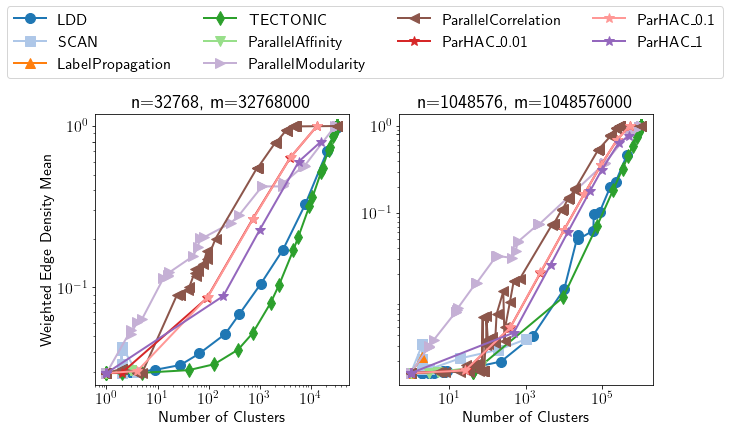

In [236]:
x_axis = "numberClusters"
y_axis = "weightedEdgeDensityMean"
plot_edge_density(df, x_axis, y_axis, "Weighted Edge Density Mean")
plt.savefig("../results/rmat.pdf", bbox_inches='tight')

In [221]:
 df["Clusterer Name"].unique()

array(['LDDClusterer', 'SCANClusterer', 'LabelPropagationClusterer',
       'TECTONICClusterer', 'ParallelAffinityClusterer',
       'ParallelModularityClusterer', 'ParallelCorrelationClusterer',
       'ParHACClusterer', 'ParHACClusterer_0.01', 'ParHACClusterer_0.1',
       'ParHACClusterer_1'], dtype=object)

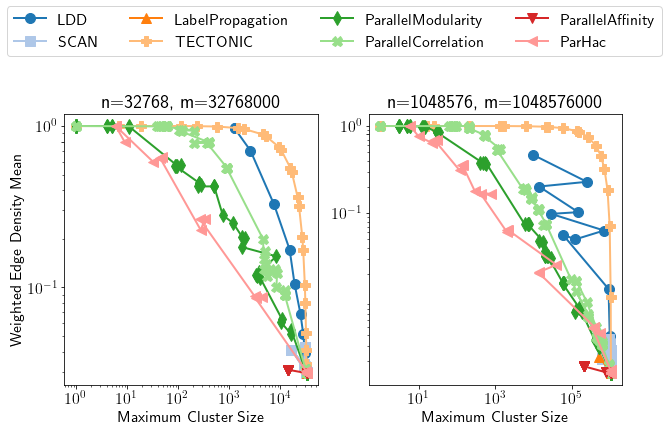

In [162]:
x_axis = "clusterSizes_maximum"
y_axis = "weightedEdgeDensityMean" 
axes = plot_edge_density(df, x_axis, y_axis,  "Weighted Edge Density Mean")
for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Maximum Cluster Size")
plt.savefig("../results/rmat_max.pdf", bbox_inches='tight')   


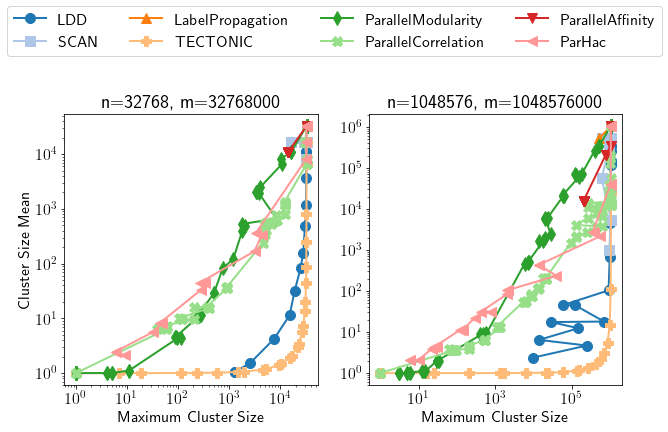

In [163]:
x_axis = "clusterSizes_maximum"
y_axis = "clusterSizes_mean" 
axes = plot_edge_density(df, x_axis, y_axis,  "Cluster Size Mean")
for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Maximum Cluster Size")
plt.savefig("../results/rmat_mean.pdf", bbox_inches='tight')   

array([<Axes: title={'center': 'n=32768, m=32768000'}, xlabel='Number of Clusters', ylabel='Weighted Edge Density Mean'>,
       <Axes: title={'center': 'n=1048576, m=1048576000'}, xlabel='Number of Clusters'>],
      dtype=object)

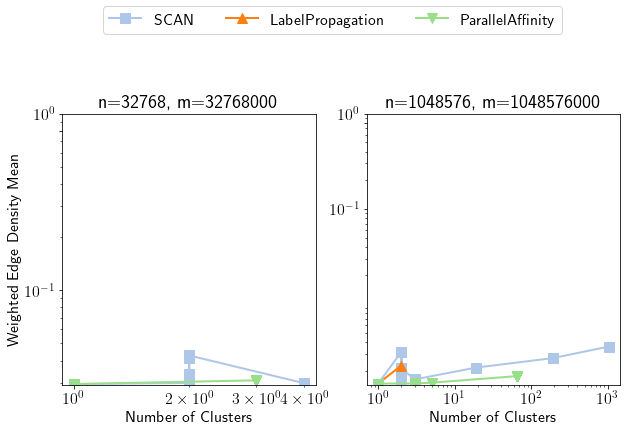

In [197]:
df_subset = df[df["Clusterer Name"].isin(["LabelPropagationClusterer", 'ParallelAffinityClusterer', "SCANClusterer"])]
plot_edge_density(df_subset, x_axis, y_axis, "Weighted Edge Density Mean")

In [198]:
print(df_subset.to_csv())

,Unnamed: 0,Clusterer Name,Input Graph,Threads,Config,Round,Cluster Time,filename,numberNodes,numberClusters,clusterSizes_minimum,clusterSizes_maximum,clusterSizes_mean,clusterSizes_total,clusterSizes_count,edgeDensity_minimum,edgeDensity_maximum,edgeDensity_mean,edgeDensity_total,edgeDensity_count,weightedEdgeDensityMean,Ground Truth
34,34,SCANClusterer,rmat_32768_32768000,60,"mu: 2,epsilon: 0.01",0,1.80151,/home/sy/mount-data/RMAT/rmat_32768_32768000.gbbs.txt,32768,1,32768,32768,32768.0,32768,1,0.0294356518866876,0.0294356518866876,0.0294356518866876,0.0294356518866876,1,0.0294356518866876,cmty.txt
35,35,SCANClusterer,rmat_32768_32768000,60,"mu: 2,epsilon: 0.05",0,1.81844,/home/sy/mount-data/RMAT/rmat_32768_32768000.gbbs.txt,32768,1,32768,32768,32768.0,32768,1,0.0294356518866876,0.0294356518866876,0.0294356518866876,0.0294356518866876,1,0.0294356518866876,cmty.txt
36,36,SCANClusterer,rmat_32768_32768000,60,"mu: 2,epsilon: 0.1",0,1.79009,/home/sy/mount-data/RMAT/rmat_32768_32768000.gb

array([<Axes: title={'center': 'n=32768, m=32768000'}, xlabel='Number of Clusters', ylabel='Edge Density Mean'>,
       <Axes: title={'center': 'n=1048576, m=1048576000'}, xlabel='Number of Clusters'>],
      dtype=object)

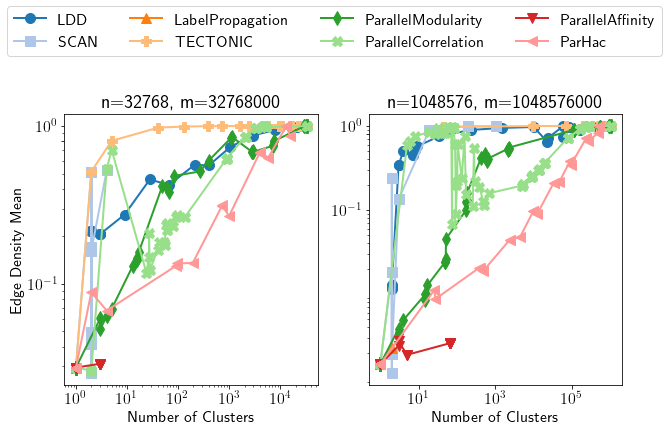

In [168]:
x_axis = "numberClusters"
y_axis = "edgeDensity_mean"
plot_edge_density(df, x_axis, y_axis, "Edge Density Mean")

In [166]:
# x_axis = "numberClusters"
# y_axis = "weightedTriangleDensityMean"
# plot_edge_density(df, x_axis, y_axis)

In [167]:
# x_axis = "numberClusters"
# y_axis = "triangleDensity_mean"
# plot_edge_density(df, x_axis, y_axis)